NameError: name 'torch' is not defined

In [7]:
import neuralprocesses.torch as nps
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [8]:
data = pd.read_csv('data_hare_lynx.csv')
data = data.to_numpy()

In [9]:
cnp = nps.construct_convgnp(dim_x=1, dim_y=2, likelihood="het")


In [10]:
def lotka_volterra(z, t, alpha, beta, gamma, delta):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Generate synthetic data
def generate_synthetic_data(alpha, beta, gamma, delta, x0, y0, t_span, noise_std=0.0, n_trajectories=10):
    data = []
    t = np.linspace(t_span[0], t_span[1], t_span[2])
    time = []
    hares = []
    lynx = []

    true_hares = []
    true_lynx = []
    for _ in range(n_trajectories):
        x_init = x0 + np.random.uniform(-5, 5)
        y_init = y0 + np.random.uniform(-2, 2)
        z0 = [x_init, y_init]

        solution = odeint(lotka_volterra, z0, t, args=(alpha, beta, gamma, delta))
        hares, lynx = solution.T

        # Add Gaussian noise
        hares_noisy = hares + np.random.normal(0, noise_std, size=hares.shape)
        lynx_noisy = lynx + np.random.normal(0, noise_std, size=lynx.shape)


        # Store trajectory
        time.append(t)
        true_hares.append(hares_noisy) #this mimics the error in teh data genertion
        true_lynx.append(lynx_noisy )


    return time, true_hares, true_lynx

# Example parameters
alpha, beta, gamma, delta = 0.1, 0.02, 0.3, 0.01
x0, y0 = 40, 9
t_span = (0, 200, 100)
noise_std = 2.0
n_trajectories = 1000
data_synthetic = generate_synthetic_data(alpha, beta, gamma, delta, x0, y0, t_span, noise_std, n_trajectories)
train_time, train_hares, train_lynx = data_synthetic



In [11]:
def split_context_target(time, hares, lynx, n_context, n_target):
    context_data = {}
    target_data = {}

    time_c, h_c, l_c = [], [], []
    time_t, h_t, l_t = [], [], []
    for i in range(len(time)):
        time_i = time[i]
        hares_i = hares[i]
        lynx_i = lynx[i]

        idx = np.random.choice(len(time_i), size=n_context + n_target, replace=False)
        context_idx = idx[:n_context]
        target_idx = idx[n_context:]


        time_c.append(time_i[context_idx])
        h_c.append(hares_i[context_idx])
        l_c.append(lynx_i[context_idx])

        time_t.append(time_i[target_idx])
        h_t.append(hares_i[target_idx])
        l_t.append(lynx_i[target_idx])

    context_data['time'] = np.array(time_c)
    context_data['hares'] = np.array(h_c)
    context_data['lynx'] = np.array(l_c)
    target_data['time'] = np.array(time_t)
    target_data['hares'] = np.array(h_t)
    target_data['lynx'] = np.array(l_t)

    return context_data, target_data

# Split data
n_context = 50
n_target = 50
context_data, target_data = split_context_target(train_time, train_hares, train_lynx,
                                                 n_context, n_target)

synth_train_x = context_data['time']
synth_train_y = np.stack((context_data['hares'], context_data['lynx']), axis=1)
synth_test_x = target_data['time']
synth_test_y = np.stack((target_data['hares'], target_data['lynx']), axis=1)

In [12]:
synth_train_y.shape

(1000, 2, 50)

In [13]:
    # shapes are `(batch_size, dimensionality, num_data)`.
#get a torch dataloader to get the dataset to dataloder
synth_train_x = torch.from_numpy(synth_train_x).unsqueeze(1).float()
synth_train_y = torch.from_numpy(synth_train_y).float()
synth_test_x = torch.from_numpy(synth_test_x).unsqueeze(1).float()
synth_test_y = torch.from_numpy(synth_test_y).float()



In [14]:
synth_train_y.shape

torch.Size([1000, 2, 50])

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(synth_train_x, synth_train_y, synth_test_x, synth_test_y),
    batch_size=32,
    shuffle=True,
)



In [16]:
time = data[:, 0]
hare = data[:, 1]
lynx = data[:, 2]

In [17]:
time = time - time[0]

In [18]:
idx = np.random.choice(len(time), size=72, replace=False)
context_time = time[idx]
context_hare = hare[idx]
context_lynx = lynx[idx]

target_time = np.delete(time, idx)
target_hare = np.delete(hare, idx)
target_lynx = np.delete(lynx, idx)



In [19]:
opt = torch.optim.Adam(cnp.parameters(), 1e-2)


Stack the target_hare and target_lynx

In [ ]:
def to_tensor(data):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    return torch.tensor(data, dtype=torch.float32).to(device)
epochs = 32

def loss_fn(model, xc, yc, xt, yt):
    loss = -torch.mean(
        nps.loglik(
            model, xc, yc, xt, yt,
            normalise=True,
                   )
        )

    loss.dtype = torch.float32
    return loss

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#set device to macos
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

cnp.to(device)
cnp.train();


In [47]:
context_x =to_tensor(context_time).unsqueeze(0).unsqueeze(0)
target_x = to_tensor(target_time).unsqueeze(0).unsqueeze(0)

context_hare = to_tensor(context_hare).unsqueeze(0).unsqueeze(0)
context_lynx = to_tensor(context_lynx).unsqueeze(0).unsqueeze(0)
target_hare = to_tensor(target_hare).unsqueeze(0).unsqueeze(0)
target_lynx = to_tensor(target_lynx).unsqueeze(0).unsqueeze(0)

context_y = torch.cat((context_hare, context_lynx), dim=1)
target_y = torch.cat((target_hare, target_lynx), dim=1)

/var/folders/45/yj686rqn3bq66c_r2zhytrcc0000gp/T/ipykernel_11229/2698603270.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32).to(device)


In [48]:
context_y.shape

torch.Size([1, 2, 1, 1, 1, 1, 72])

In [49]:
context_x.shape, target_x.shape, context_y.shape

(torch.Size([1, 1, 72]),
 torch.Size([1, 1, 19]),
 torch.Size([1, 2, 1, 1, 1, 1, 72]))

In [50]:
def train(epochs, model, dataloader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.train()
    for epoch in range(epochs):

        for context_x, context_y, target_x, target_y in dataloader:
            print(context_x.shape, context_y.shape, target_x.shape,
                  target_y.shape)
            epoch_loss = 0.0


            # Forward pass
            loss = loss_fn(model, context_x, context_y, target_x, target_y)

            epoch_loss += loss.item()
            opt.zero_grad()

            # Backward pass
            loss.backward()
            opt.step()

            # Log loss
            # Log loss
            if (epoch + 1) % 25 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(context_x):.4f}")

        return model

model = train(1024, cnp, train_dataloader )

torch.Size([32, 1, 50]) torch.Size([32, 2, 50]) torch.Size([32, 1, 50]) torch.Size([32, 2, 50])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [51]:
cnp.dtype = torch.float32

In [52]:
target_x.dtype, cnp.dtype,

(torch.float32, torch.float32)

In [54]:
for epoch in range(1024):
    epoch_loss = 0.0
    cnp.to(device)
    context_x.to(device)
    context_y.to(device)
    target_x.to(device)
    target_y.to(device)

    #change dtyp e of all to use float 32
    context_x = context_x.type(torch.float32)
    context_y = context_y.type(torch.float32)
    target_x = target_x.type(torch.float32)
    target_y = target_y.type(torch.float32)
        
    # Forward pass
    # Compute loss
    loss = loss_fn(cnp, context_x, context_y, target_x, target_y)

    epoch_loss += loss.item()
    opt.zero_grad()

    # Backward pass
    loss.backward()
    opt.step()

    # Log loss
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(context_x):.4f}")

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [42]:
mean, var, noiseless_samples, noisy_samples = nps.predict(
    cnp.to("cpu"),
    context_x.to("cpu"),  # Context inputs
    context_y.to("cpu"),  # Context outputs
    target_x.to("cpu"),  # Target inputs
)

RuntimeError: Given groups=1, weight of size [64, 3, 5], expected input[2, 2, 5824] to have 3 channels, but got 2 channels instead

In [ ]:
mean.shape

NameError: name 'mean' is not defined

In [ ]:
var.shape

NameError: name 'var' is not defined

In [ ]:


predicted_mean_hare = mean[:, 0, :].detach().numpy().squeeze(0)
predicted_mean_lynx = mean[:, 1, :].detach().numpy().squeeze(0)

pred_std_hare = var[:, 0, :].detach().numpy().squeeze(0)**0.5
pred_std_lynx = var[:, 1, :].detach().numpy().squeeze(0)**0.5

time = target_x.cpu().detach().numpy().squeeze(0).squeeze(0)


sorted_indices = np.argsort(time)
time = time[sorted_indices]
predicted_mean_hare = predicted_mean_hare[sorted_indices]
predicted_mean_lynx = predicted_mean_lynx[sorted_indices]
pred_std_hare = pred_std_hare[sorted_indices]
pred_std_lynx = pred_std_lynx[sorted_indices]

true_hare = target_y.cpu().detach().numpy().squeeze(0)[0, :][sorted_indices]
true_lynx = target_y.cpu().detach().numpy().squeeze(0)[1, :][sorted_indices]
true_hare.shape

NameError: name 'mean' is not defined

In [ ]:
plt.figure(figsize=(20, 9))

sns.scatterplot(x=target_x.cpu().detach().numpy().squeeze(0).squeeze(0),
             y=mean[:, 0, :].detach().numpy().squeeze(0),
                label='Predicted hare', color='red')
sns.scatterplot(x=target_x.cpu().detach().numpy().squeeze(0).squeeze(0),
             y=mean[:, 1, :].detach().numpy().squeeze(0),
                label='Predicted lynx', color='blue')


plt.fill_between(
    time,
    predicted_mean_hare - 1 * pred_std_hare,
    predicted_mean_hare + 1 * pred_std_hare,
    color='red',
    alpha=0.3,
    label='Predicted hare'
)

plt.fill_between(
    time,
    predicted_mean_lynx - 1 * pred_std_lynx,
    predicted_mean_lynx + 1 * pred_std_lynx,
    color='blue',
    alpha=0.3,
    label='Predicted lynx'
)


plt.scatter(target_x.cpu().detach().numpy().squeeze(0).squeeze(0), true_hare, color='r', label='True hare',
            marker='x')
plt.scatter(target_x.cpu().detach().numpy().squeeze(0).squeeze(0), true_lynx, color='b', label='True lynx',
            marker='x')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.title('Population Dynamics with Predicted Mean and Variance', fontsize=16)
plt.legend(fontsize=9)
plt.grid(True)


In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 6))

# Seaborn line plot for predicted mean
sns.scatterplot(x=target_x.cpu().detach().numpy().squeeze(0).squeeze(0),
             y=mean.detach().numpy().squeeze(0).squeeze(0),
                label='Predicted Mean', color='green')


pred_mean = mean.detach().numpy().squeeze(0).squeeze(0)
pred_std = var.detach().numpy().squeeze(0).squeeze(0)**0.5
time = target_x.cpu().detach().numpy().squeeze(0).squeeze(0)
true_population = target_y.cpu().detach().numpy().squeeze(0).squeeze(0)
# Seaborn fill for predicted variance (95% CI)

#sort time and pred_mean, pred_var together
sorted_indices = np.argsort(time)
time = time[sorted_indices]
pred_mean = pred_mean[sorted_indices]
pred_std = pred_std[sorted_indices]
true_population = true_population[sorted_indices]


plt.fill_between(
    time,
    pred_mean - 1 * pred_std,
    pred_mean + 1 * pred_std,
    color='green',
    alpha=0.3,
    label='Predicted Variance (95% CI)',
)

# Scatter true population
sns.scatterplot(x=time, y=true_population, color='blue', label='True Population', alpha=0.8)

# Add labels and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.title('Population Dynamics with Predicted Mean and Variance', fontsize=16)
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


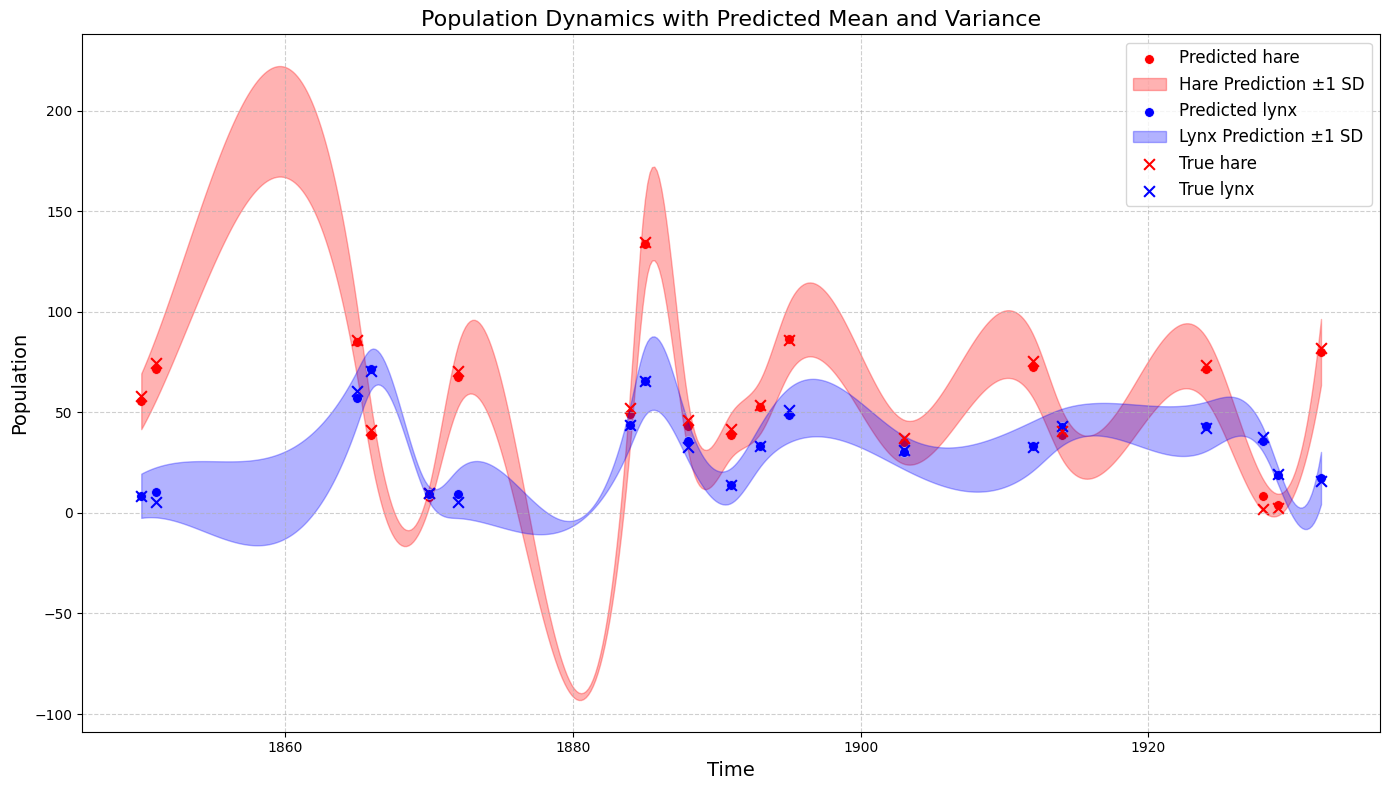

In [ ]:
from scipy.interpolate import interp1d

predicted_mean_hare = mean[:, 0, :].detach().numpy().squeeze(0)
predicted_mean_lynx = mean[:, 1, :].detach().numpy().squeeze(0)
pred_std_hare = np.sqrt(var[:, 0, :].detach().numpy().squeeze(0))
pred_std_lynx = np.sqrt(var[:, 1, :].detach().numpy().squeeze(0))
time = target_x.cpu().detach().numpy().squeeze(0).squeeze(0)

# Sorting data for plotting
sorted_indices = np.argsort(time)
time = time[sorted_indices]
predicted_mean_hare = predicted_mean_hare[sorted_indices]
predicted_mean_lynx = predicted_mean_lynx[sorted_indices]
pred_std_hare = pred_std_hare[sorted_indices]
pred_std_lynx = pred_std_lynx[sorted_indices]
true_hare = target_y.cpu().detach().numpy().squeeze(0)[0, :][sorted_indices]
true_lynx = target_y.cpu().detach().numpy().squeeze(0)[1, :][sorted_indices]

# Interpolation for smooth fill_between areas
high_res_time = np.linspace(time.min(), time.max(), 500)
hare_mean_interp = interp1d(time, predicted_mean_hare, kind='cubic')
lynx_mean_interp = interp1d(time, predicted_mean_lynx, kind='cubic')
hare_std_interp = interp1d(time, pred_std_hare, kind='cubic')
lynx_std_interp = interp1d(time, pred_std_lynx, kind='cubic')

smooth_hare_mean = hare_mean_interp(high_res_time)
smooth_lynx_mean = lynx_mean_interp(high_res_time)
smooth_hare_std = hare_std_interp(high_res_time)
smooth_lynx_std = lynx_std_interp(high_res_time)

# Plotting
plt.figure(figsize=(14, 8))

# Predicted hare population
sns.scatterplot(
    x=time,
    y=predicted_mean_hare,
    label='Predicted hare',
    color='red',
    s=50,
)
plt.fill_between(
    high_res_time,
    smooth_hare_mean - smooth_hare_std,
    smooth_hare_mean + smooth_hare_std,
    color='red',
    alpha=0.3,
    label='Hare Prediction ±1 SD',
)

# Predicted lynx population
sns.scatterplot(
    x=time,
    y=predicted_mean_lynx,
    label='Predicted lynx',
    color='blue',
    s=50,
)
plt.fill_between(
    high_res_time,
    smooth_lynx_mean - smooth_lynx_std,
    smooth_lynx_mean + smooth_lynx_std,
    color='blue',
    alpha=0.3,
    label='Lynx Prediction ±1 SD',
)

# True hare population
plt.scatter(
    time,
    true_hare,
    color='red',
    marker='x',
    s=60,
    label='True hare',
)

# True lynx population
plt.scatter(
    time,
    true_lynx,
    color='blue',
    marker='x',
    s=60,
    label='True lynx',
)

# Axes labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.title('Population Dynamics with Predicted Mean and Variance', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

Extrapolation outside of the regions

In [ ]:
time

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1850., 1851., 1865., 1866., 1870., 1872., 1884., 1885., 1888.,
       1891., 1893., 1895., 1903., 1912., 1914., 1924., 1928., 1929.,
       1932., 1932., 1933., 1934., 1935., 1936., 1937., 1938., 1939.,
       1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947., 1948.,
       1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957.,
       1958., 1959., 1960., 1962., 1963., 1964., 1965., 1966., 1967.,
       1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976.,
       1977., 1978., 1979., 1980., 1981.], dtype=float32)

In [ ]:
target_x.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 1, 19])

In [ ]:
#append a list from 1932 to 1960 to target_x
target_x_new = torch.cat((target_x, torch
                      .tensor(np.arange(1950, 1970), dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0)), dim=2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#delete duplicates from target_x_new
target_x_new = torch.unique(target_x_new, dim=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
mean, var, noiseless_samples, noisy_samples = nps.predict(
    cnp.to("cpu"),
    context_x.to("cpu"),  # Context inputs
    context_y.to("cpu"),  # Context outputs
    target_x_new.to("cpu"),  # Target inputs
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


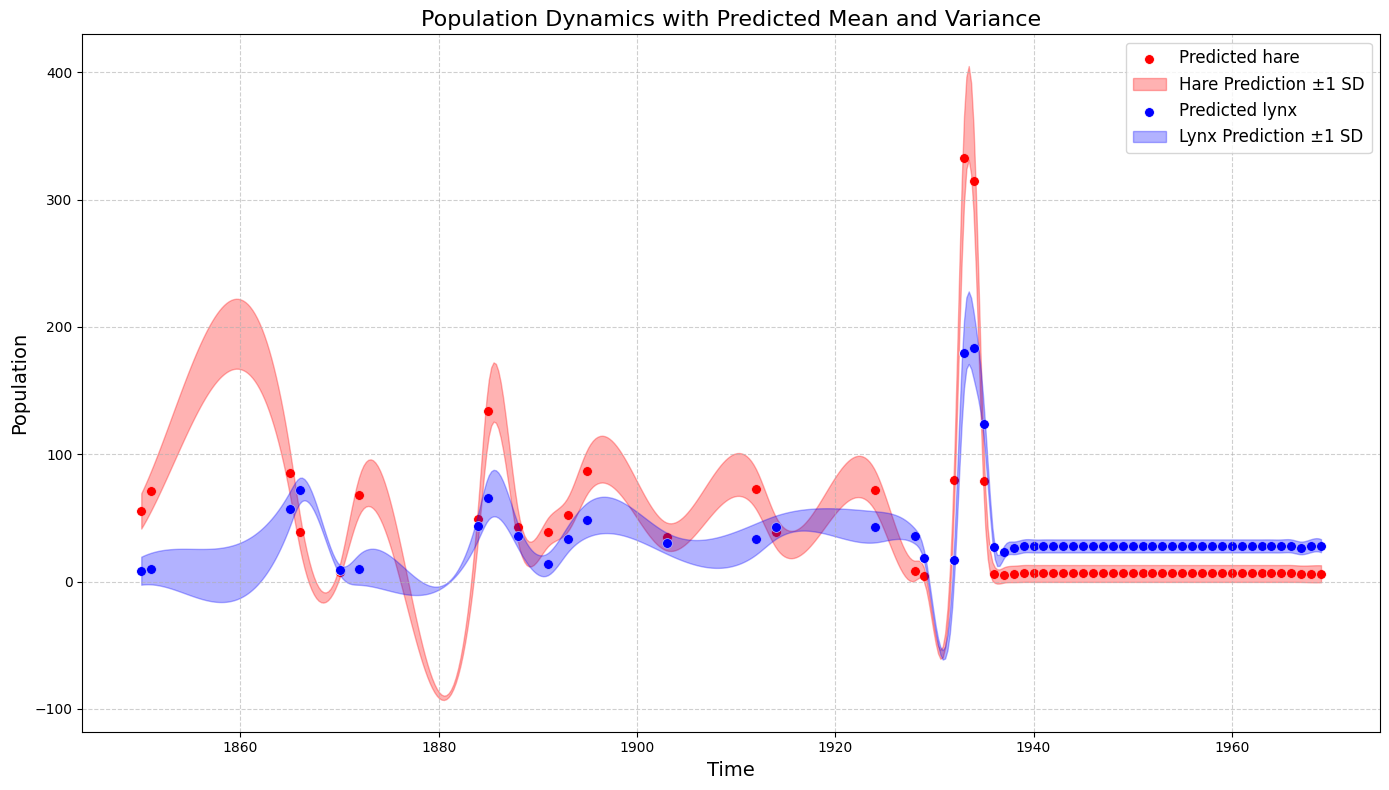

In [ ]:
from scipy.interpolate import interp1d

predicted_mean_hare = mean[:, 0, :].detach().numpy().squeeze(0)
predicted_mean_lynx = mean[:, 1, :].detach().numpy().squeeze(0)
pred_std_hare = np.sqrt(var[:, 0, :].detach().numpy().squeeze(0))
pred_std_lynx = np.sqrt(var[:, 1, :].detach().numpy().squeeze(0))
time = target_x_new.cpu().detach().numpy().squeeze(0).squeeze(0)

# Sorting data for plotting
sorted_indices = np.argsort(time)
time = time[sorted_indices]
predicted_mean_hare = predicted_mean_hare[sorted_indices]
predicted_mean_lynx = predicted_mean_lynx[sorted_indices]
pred_std_hare = pred_std_hare[sorted_indices]
pred_std_lynx = pred_std_lynx[sorted_indices]
# true_hare = target_y.cpu().detach().numpy().squeeze(0)[0, :][sorted_indices]
# true_lynx = target_y.cpu().detach().numpy().squeeze(0)[1, :][sorted_indices]

# Interpolation for smooth fill_between areas
high_res_time = np.linspace(time.min(), time.max(), 500)
hare_mean_interp = interp1d(time, predicted_mean_hare, kind='cubic')
lynx_mean_interp = interp1d(time, predicted_mean_lynx, kind='cubic')
hare_std_interp = interp1d(time, pred_std_hare, kind='cubic')
lynx_std_interp = interp1d(time, pred_std_lynx, kind='cubic')

smooth_hare_mean = hare_mean_interp(high_res_time)
smooth_lynx_mean = lynx_mean_interp(high_res_time)
smooth_hare_std = hare_std_interp(high_res_time)
smooth_lynx_std = lynx_std_interp(high_res_time)

# Plotting
plt.figure(figsize=(14, 8))

# Predicted hare population
sns.scatterplot(
    x=time,
    y=predicted_mean_hare,
    label='Predicted hare',
    color='red',
    s=50,
)
plt.fill_between(
    high_res_time,
    smooth_hare_mean - smooth_hare_std,
    smooth_hare_mean + smooth_hare_std,
    color='red',
    alpha=0.3,
    label='Hare Prediction ±1 SD',
)

# Predicted lynx population
sns.scatterplot(
    x=time,
    y=predicted_mean_lynx,
    label='Predicted lynx',
    color='blue',
    s=50,
)
plt.fill_between(
    high_res_time,
    smooth_lynx_mean - smooth_lynx_std,
    smooth_lynx_mean + smooth_lynx_std,
    color='blue',
    alpha=0.3,
    label='Lynx Prediction ±1 SD',
)

# True hare population
# plt.scatter(
#     time,
#     true_hare,
#     color='red',
#     marker='x',
#     s=60,
#     label='True hare',
# )

# # True lynx population
# plt.scatter(
#     time,
#     true_lynx,
#     color='blue',
#     marker='x',
#     s=60,
#     label='True lynx',
# )

# Axes labels, title, and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.title('Population Dynamics with Predicted Mean and Variance', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
